 # Analysis and prediction of super-enhancers
 ____

Filled notebook without tasks = 5 points

Additional tasks = 15 points (+5 Bonus)

 
# Intoduction


In the notebook the super-enhancers prediction is made by means of classical Machine Learning Models.

The notebook was made based on the article [Analysis and prediction of super-enhancers using sequence and chromatin signatures](https://www.biorxiv.org/content/10.1101/105262v1.full) and appropriate [github repository](https://github.com/asntech/improse).

## Biology problem statement

### Background

In genetics, an enhancer is a short (50–1500 bp) region of DNA that can be bound by proteins (activators) to increase the likelihood that transcription of a particular gene will occur.

A myriad of transcription factors bind to enhancers and regulate gene expression by recruiting coactivators and RNA polymerase II to target genes.

### What is super-enhancers and why care?

DNA enhancers regions have been
identified and classified into **super-enhancers (SEs)** and **typical enhancers (TEs)** by using ChIP-seq
signal. 

**Super-enhancers** form clusters of active enhancers, are celltype specific, associated with key cell identity genes, and linked to many biological processes which
define the cell identity. These **super-enhancers** are densely loaded with the Mediator complex,
master transcription factors and chromatin regulators. Many disease- and trait-associated
single nucleotide polymorphisms (SNPs) have been found in these regions. 

**Super-enhancers**
differ from **typical enhancers** in terms of size, ChIP-seq density of various cofactors, DNA motif
content, DNA methylation level, enhancer RNA (eRNA) abundance, ability to activate transcription
and sensitivity to perturbation. Further, studies have found super-enhancers in
multiple cancers and demonstrated their importance in cellular-identity and disease and emphasized
their use as potential biomarkers.

### What is problem?

ChIP-seq data
for MED1 - part of Mediator complex working with RNA polymerase II optimally differentiated super-enhancers and typical enhancers by comparing it with
enhancer marks, including **H3K27ac**, **H3K4me1** and **DNase I** hypersensitivity. **BRD4**, a member
of the BET protein family, was also used to distinguish super-enhancers from typical enhancers as it
is highly correlated with MED1. **H3K27ac** was extensively used to create a catalogue of super-enhancers across 86 different human cell-types and tissues due to its availability. Other studies
used the coactivator protein **P300** to define super-enhancers.

However, the knowledge about
these factors’ ability to define a set of super-enhancers in a particular cell-type and their relative and
combinatorial importance remains limited. Master transcription factors which might form the super-enhancer domains are largely unknown for most of the cell-types, while performing ChIP-seq for the
Mediator complex is difficult and costly.

Machine Learning methods are able to model such complex dependencies between enhancer's type and external factors.

## Machine Learning Problem Statement

Binary classification task - predict class of the enhancer (0 - typical enhancer and 1 - super enhancer) based on the set of features - external factors of the enhancer's environment.



**Dataset description**

10020 rows, 39 features. Target variable - **Class**.

| Feature        | Description           |
| :------------- |:-------------|
|chrom|number of chromatin|
|start, end| number of the first and the last nucleotide|
| H3K27ac, H3K4me1,  H3K4me3, H3K9me3     | histone modifications | 
|Med12, Cdk8|sub-units of Mediator complex|
| Cdk9      |  P-TFEb subunit      |
|p300, CBP| transcriptional co-activating proteins |
|Pol2| RNA polymerase II|
|Lsd1, Mi2b|subunits of Lsd1-NuRD complex|
|Brg1, Brd4, CHD7|other chromatin regulators|
|Smc1, Nipbl| Cohesin|
|Oct4, Sox2, Nanog, Esrrb, Klf4, Tcfcp2l1, Prdm14, Nr5a2, Smad3, Stat3 and Tcf3| transcription factors|
|DNaseI|DNA hypersensitive site|
|HDAC, HDAC2|enzymes that remove acetyl groups from an amino acid on a histone|
|AT_content|content of A and T nucleotides|
|GC_content|content of C and G nucleotides|
|phastConsP, phastCons|probability that each nucleotide belongs to a conserved element (from HMM prediction model)|
|repeat_fraction| - |
|length|number of nucleotides|

# Content
_____

1. Getting familiar with gene expression datasets
2. Using the Machine Learning Models pipeline for model construction
3. Apply different metrics and models interpretation algorithms

In [1]:
import pandas as pd
import numpy as np

#1. Data preprocessing

1. Get information about data type and missing values
2. Visualize data
3. Split data
4. Check balance of classes

In [4]:
# !wget https://raw.githubusercontent.com/asntech/improse/master/improse/data/original_data.csv

In [5]:
data = pd.read_csv('original_data.csv')

In [6]:
data.head()

,chrom,start,end,Class,H3K27ac,H3K4me1,H3K4me3,H3K9me3,Brd4,Cdk8,...,Klf4,Prdm14,Tcfcp2I1,Nr5a2,AT_content,GC_content,phastCons,phastConsP,repeat_fraction,length
0,chr1,13049615,13050323,SE,0.2018,1.4146,0.0749,0.1198,0.7075,0.6613,...,0.4839,1.5489,0.8829,0.1934,0.552260,0.447740,0.057415,0.057418,0.810734,708
1,chr1,13061206,13061924,SE,0.1342,0.4785,0.5477,0.2809,0.4630,1.6258,...,0.0315,0.1724,0.1641,0.0000,0.572423,0.427577,0.128439,0.128439,0.738162,718
2,chr1,13063645,13065360,SE,0.6214,0.7748,0.1633,0.0000,1.5622,2.5607,...,0.1867,5.2407,0.0000,0.2011,0.592420,0.407580,0.220057,0.230713,0.092711,1715
3,chr1,13071010,13071067,SE,0.9484,1.8778,0.0000,0.0000,0.8669,1.8424,...,0.0000,1.0517,0.2885,0.4231,0.649123,0.350877,0.050386,0.050386,0.000000,57
4,chr1,13074460,13075741,SE,1.1076,0.7386,0.0000,0.0000,3.2876,3.8653,...,2.3268,63.2990,34.6054,0.1112,0.548009,0.451991,0.054896,0.054997,0.231850,1281


In [7]:
TARGET_COLUMN ='Class'
CATEG_FEATURES = ['chrom']
CV_SPLITS = 10
SMOTE_K_NEIGHBOURS = 5

In [11]:
# Check missing values
print(data.shape)
print(data.dropna().shape)

(10020, 41)
(10020, 41)


Размеры не изменились. 

In [28]:
data.dtypes[data.dtypes != float]

chrom     object
start      int64
end        int64
Class     object
length     int64
dtype: object

Только две столбца с именоваными переменными. При это одна из них отклик. 

array([[<AxesSubplot:title={'center':'start'}>,
        <AxesSubplot:title={'center':'end'}>,
        <AxesSubplot:title={'center':'H3K27ac'}>,
        <AxesSubplot:title={'center':'H3K4me1'}>,
        <AxesSubplot:title={'center':'H3K4me3'}>,
        <AxesSubplot:title={'center':'H3K9me3'}>],
       [<AxesSubplot:title={'center':'Brd4'}>,
        <AxesSubplot:title={'center':'Cdk8'}>,
        <AxesSubplot:title={'center':'Cdk9'}>,
        <AxesSubplot:title={'center':'Med12'}>,
        <AxesSubplot:title={'center':'p300'}>,
        <AxesSubplot:title={'center':'CBP'}>],
       [<AxesSubplot:title={'center':'Pol2'}>,
        <AxesSubplot:title={'center':'Lsd1'}>,
        <AxesSubplot:title={'center':'Brg1'}>,
        <AxesSubplot:title={'center':'Smc1'}>,
        <AxesSubplot:title={'center':'Nipbl'}>,
        <AxesSubplot:title={'center':'Mi2b'}>],
       [<AxesSubplot:title={'center':'CHD7'}>,
        <AxesSubplot:title={'center':'HDAC2'}>,
        <AxesSubplot:title={'center':'HDAC'

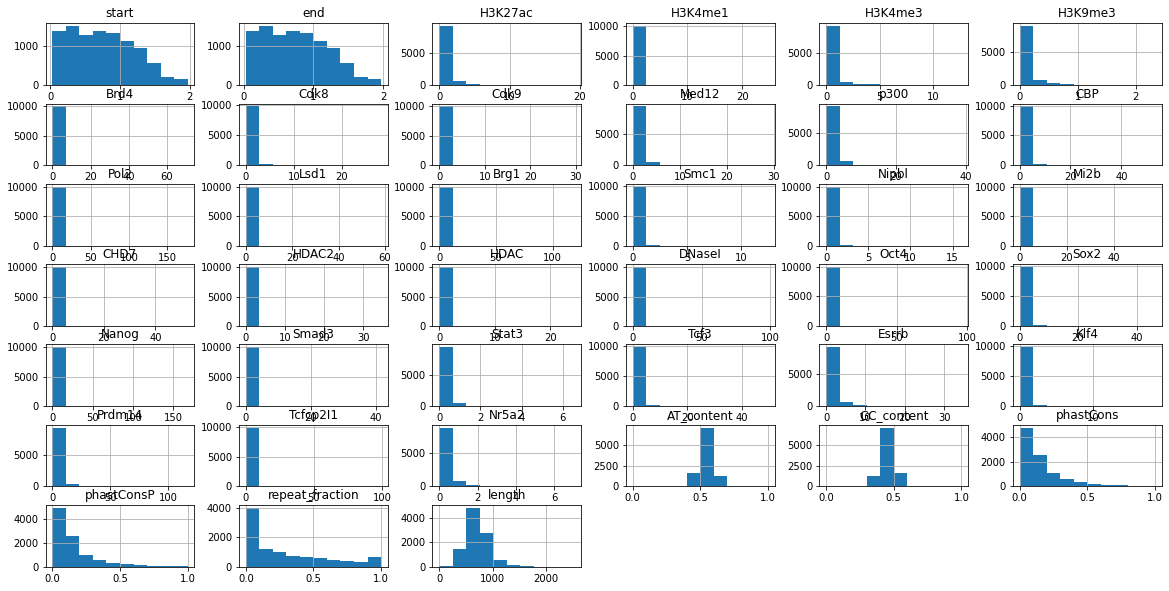

In [30]:
# Plot histograms of features

data.hist(figsize = (20,10))

In [31]:
# Split data
from sklearn.model_selection import train_test_split, StratifiedKFold

y = data[TARGET_COLUMN].map({'TE': 0, 'SE': 1})
X = data.drop(columns = [TARGET_COLUMN]+CATEG_FEATURES)

X_train_val,  X_test, y_train_val, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify = None)

skf = StratifiedKFold(n_splits=CV_SPLITS,  random_state=42, shuffle=True)

<AxesSubplot:>

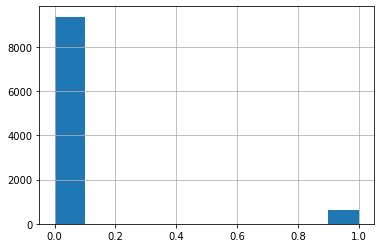

In [32]:
# Check class imbalance
y.hist()

#### Task 1 (3 points)

Encode `CATEG_FEATURES` during preprocessing and compare results of the models with/without this feature. 
What type of encoding is it better to use?

Теперь сделаем таблицу где мы не выкидываем из рассмотрения колонку 'chrom'. С помощью one-hot-encoding  сделаем новые столбцы. Сначала проверим какие есть значения в ячейках. 

In [33]:
data2 = data.copy()

In [34]:
a = np.unique(data2['chrom'])
a.sort()
print(a)

['chr1' 'chr10' 'chr11' 'chr12' 'chr13' 'chr14' 'chr15' 'chr16' 'chr17'
 'chr18' 'chr19' 'chr2' 'chr3' 'chr4' 'chr5' 'chr6' 'chr7' 'chr8' 'chr9'
 'chrX']


  Закодируем все хромосомы кроме X, для того, чтобы избежать коллинеарности в данных. 

In [35]:
data2["chr1"] = list(map(int, data2['chrom']=='chr1'))
data2["chr2"] = list(map(int, data2['chrom']=='chr2'))
data2["chr3"] = list(map(int, data2['chrom']=='chr3'))
data2["chr4"] = list(map(int, data2['chrom']=='chr4'))
data2["chr5"] = list(map(int, data2['chrom']=='chr5'))
data2["chr6"] = list(map(int, data2['chrom']=='chr6'))
data2["chr7"] = list(map(int, data2['chrom']=='chr7'))
data2["chr8"] = list(map(int, data2['chrom']=='chr8'))
data2["chr9"] = list(map(int, data2['chrom']=='chr9'))
data2["chr10"] = list(map(int, data2['chrom']=='chr10'))
data2["chr11"] = list(map(int, data2['chrom']=='chr11'))
data2["chr12"] = list(map(int, data2['chrom']=='chr12'))
data2["chr13"] = list(map(int, data2['chrom']=='chr13'))
data2["chr14"] = list(map(int, data2['chrom']=='chr14'))
data2["chr15"] = list(map(int, data2['chrom']=='chr15'))
data2["chr16"] = list(map(int, data2['chrom']=='chr16'))
data2["chr17"] = list(map(int, data2['chrom']=='chr17'))
data2["chr18"] = list(map(int, data2['chrom']=='chr18'))
data2["chr19"] = list(map(int, data2['chrom']=='chr19'))

In [36]:
data2 = data2.drop(columns = ['chrom'])

In [64]:
# Split data
from sklearn.model_selection import train_test_split, StratifiedKFold

y = data2[TARGET_COLUMN].map({'TE': 0, 'SE': 1})
X_up = data2.drop(columns = [TARGET_COLUMN])

X_train_val_up,  X_test_up, y_train_val_up, y_test_up = train_test_split(X_up, y, train_size = 0.8, random_state = 42, shuffle = True, stratify = None)

skf = StratifiedKFold(n_splits=CV_SPLITS,  random_state=42, shuffle=True)

# 2. Create model

1. Fix class imbalance
2. Optimize model's hyperparameters
3. Train RandomForest model with cross-validation
4. Check ROC-AUC score for the model with best parameters

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
import sklearn

In [44]:
def get_model(model):
    '''
    Get the model from six stat-of-the-art machine learning models.
    '''
    if model=='svm':
        from sklearn.svm import SVC
        names = ["Linear SVM"]
        classifiers = [
        SVC()    
        ]
    elif model=='ab':
        from sklearn.ensemble import AdaBoostClassifier
        names = ["AdaBoost"]
        classifiers = [
        AdaBoostClassifier() 
        ]
    elif model=='knn':
        from sklearn.neighbors import KNeighborsClassifier
        names = ["K-Nearest Neighbors"]
        classifiers = [
        KNeighborsClassifier()
        ]
    elif model=='dt':
        from sklearn.tree import DecisionTreeClassifier
        names = ["Decision Tree"]
        classifiers = [
        DecisionTreeClassifier()   
        ]
    elif model=='nb':
        from sklearn.naive_bayes import GaussianNB
        names = ["Naive Bayes"]
        classifiers = [
         GaussianNB()   
        ]
    else:
        from sklearn.ensemble import RandomForestClassifier
        names = ["Random Forest"]
        classifiers = [
        RandomForestClassifier()
        ]
    
    return classifiers

Найдём параметры лушего леса, подбор только глубины

In [45]:
model = get_model('dt')[0]
parameters = {'model__max_depth':(3, 5, 7)}
over = SMOTE(sampling_strategy=0.1, k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val, y_train_val)


In [46]:
clf.best_params_

{'model__max_depth': 3}

In [47]:
best_model = DecisionTreeClassifier(max_depth = 3)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val, y_train_val)

In [48]:
y_test_pred_proba = pipeline[1].predict_proba(X_test)[:,1]

In [54]:
print('Test ROC AUC for the best model %.2f' % roc_auc_score(y_test, y_test_pred_proba))

Test ROC AUC for the best model 0.88


Будем искать и параметры для SMOTE

In [50]:
# Add SMOTE k_neighbours parameter to the search grid
model = get_model('dt')[0]
parameters = {'model__max_depth':(3, 5, 7), 'over__k_neighbors':(5, 10)}
over = SMOTE(sampling_strategy=0.1)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val, y_train_val)


In [51]:
# Optimize Random Forest model
model = get_model('Random Forest')[0]
parameters = {'model__max_depth':(3, 5, 7), 'model__n_estimators': (100, 200), 'over__sampling_strategy':(0.1, 0.8)}
over = SMOTE(k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val, y_train_val)

In [52]:
clf.best_params_

{'model__max_depth': 7,
 'model__n_estimators': 100,
 'over__sampling_strategy': 0.1}

In [55]:
best_model = RandomForestClassifier(max_depth = 7, n_estimators = 100,)
over = SMOTE(sampling_strategy=0.1, k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val, y_train_val)
y_test_pred_proba = pipeline[1].predict_proba(X_test)[:,1]

In [56]:
print('Test ROC AUC for the best model %.2f' % roc_auc_score(y_test, y_test_pred_proba))

Test ROC AUC for the best model 0.92


Рассмотрим модель на модифицированных данных

In [59]:
model = get_model('Random Forest')[0]
parameters = {'model__max_depth':(3, 5, 7), 'model__n_estimators': (100, 200), 'over__sampling_strategy':(0.1, 0.8)}
over = SMOTE(k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [60]:
clf.best_params_

{'model__max_depth': 7,
 'model__n_estimators': 200,
 'over__sampling_strategy': 0.1}

In [62]:
best_model = RandomForestClassifier(max_depth = 7, n_estimators = 200)
over = SMOTE(sampling_strategy=0.1, k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.926


Как видно, если в модель добавить кодирование хромасом, то значение показателя качества увелиться, но не существенно. 

#### Task 2 (9 points)

Try other models from the list of SOTA models and fit the set of parameters.

* Add needed preprocessing steps (3 points). 

* What assumptions do you need to check before using NB classifier? (2 points). 

* Try to use XGBoost model,  optimize it parameters. (3 points)

(Consider using XGBoost with GPU - https://xgboost.readthedocs.io/en/latest/gpu/index.html)

* What model has the best test score? (1 point)



Для начала проведём нормализацию данных (так как для остальных методов необходимы отшкалированные данные). А также удалим явно зависимые столбцы (например длинна является разницей столбцов начала и конца, а также сумма ), чтобы наивный баес мог хоть как-то адекватно работать.  

In [66]:
from sklearn import preprocessing

# data2 = data2.drop(columns = ['AT_content', 'length', 'chrom'])


stand_1 = preprocessing.StandardScaler()
stand_1.fit(X_up)
X_up = stand_1.transform(X_up)
X_up = pd.DataFrame(X_up, index=data2.drop(columns = ['Class']).index, columns=data2.drop(columns = ['Class']).columns)
X_up = X_up.drop(columns = ['AT_content', 'length'])
X_up.head()

,start,end,H3K27ac,H3K4me1,H3K4me3,H3K9me3,Brd4,Cdk8,Cdk9,Med12,...,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,chr19
0,-1.377083,-1.377083,-0.348632,1.562065,-0.338394,0.353912,-0.041691,-0.119138,0.308567,-0.098194,...,-0.255495,-0.27025,-0.217349,-0.234196,-0.218856,-0.194985,-0.187414,-0.219356,-0.1828,-0.041225
1,-1.376826,-1.376825,-0.407592,-0.288710,0.242221,1.363730,-0.229199,0.941643,0.205870,-0.084782,...,-0.255495,-0.27025,-0.217349,-0.234196,-0.218856,-0.194985,-0.187414,-0.219356,-0.1828,-0.041225
2,-1.376771,-1.376749,0.017340,0.297109,-0.229835,-0.397025,0.613781,1.969869,0.960634,0.637503,...,-0.255495,-0.27025,-0.217349,-0.234196,-0.218856,-0.194985,-0.187414,-0.219356,-0.1828,-0.041225
3,-1.376608,-1.376622,0.302548,2.477863,-0.430373,-0.397025,0.080553,1.179865,0.395372,-0.464049,...,-0.255495,-0.27025,-0.217349,-0.234196,-0.218856,-0.194985,-0.187414,-0.219356,-0.1828,-0.041225
4,-1.376531,-1.376518,0.441401,0.225537,-0.430373,-0.397025,1.936997,3.404701,2.127211,3.393990,...,-0.255495,-0.27025,-0.217349,-0.234196,-0.218856,-0.194985,-0.187414,-0.219356,-0.1828,-0.041225


Используем остальные методы из списка. 

In [67]:
X_train_val_up,  X_test_up, y_train_val_up, y_test_up = train_test_split(X_up, y, train_size = 0.8, random_state = 42, shuffle = True, stratify = None)

Linear SVM

In [68]:
model = get_model('svm')[0]
parameters = {'model__kernel':('poly', 'linear', 'rbf'), 'over__k_neighbors':(5, 10)}
over = SMOTE(sampling_strategy=0.1)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [69]:
print(clf.best_params_)

{'model__kernel': 'linear', 'over__k_neighbors': 10}


In [125]:
best_model = sklearn.svm.SVC(kernel = 'linear')
over = SMOTE(sampling_strategy=0.1, k_neighbors=10)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)

In [126]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.5414847161572053


AdaBoost

In [78]:
model = get_model('ab')[0]
parameters = {'model__n_estimators':(50, 100, 200), 'over__k_neighbors':(5, 10)}
over = SMOTE(sampling_strategy=0.1)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [79]:
print(clf.best_params_)

{'model__n_estimators': 50, 'over__k_neighbors': 5}


In [122]:
best_model = sklearn.ensemble.AdaBoostClassifier(n_estimators = 50)
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)

In [123]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.5284552845528455


In [124]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.927


K-Nearest Neighbors

In [117]:
model = get_model('knn')[0]
parameters = {'model__n_neighbors':(2, 5, 10, 20, 30), 'over__k_neighbors':(5, 10, 15)}
over = SMOTE(sampling_strategy=0.1)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [118]:
print(clf.best_params_)

{'model__n_neighbors': 30, 'over__k_neighbors': 10}


In [119]:
best_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 30)
over = SMOTE(sampling_strategy=0.1, k_neighbors=10)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)

In [120]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.4148936170212766


In [121]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.878


Decision Tree

In [110]:
model = get_model('dt')[0]
parameters = {'model__max_depth':(3, 5, 7), 'over__k_neighbors':(5, 10, 15)}
over = SMOTE(sampling_strategy=0.1)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [111]:
print(clf.best_params_)

{'model__max_depth': 3, 'over__k_neighbors': 5}


In [114]:
best_model = sklearn.tree.DecisionTreeClassifier(max_depth = 3)
over = SMOTE(sampling_strategy=0.1, k_neighbors=5)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)

In [115]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.5035971223021583


In [116]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.881


Naive Bayes

In [107]:
best_model = get_model('nb')[0]
over = SMOTE(sampling_strategy=0.1, k_neighbors=10)
steps = [('over', over), ('model', best_model)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val_up)

In [108]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.4897959183673469


In [109]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.874


Random Forest

In [101]:
model = get_model('Random Forest')[0]
parameters = {'model__max_depth':(3, 5, 7), 'model__n_estimators': (100, 200), 'over__sampling_strategy':(0.1, 0.8)}
over = SMOTE(k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

In [103]:
print(clf.best_params_)

{'model__max_depth': 7, 'model__n_estimators': 100, 'over__sampling_strategy': 0.1}


In [141]:
best_model_RF = RandomForestClassifier(max_depth = 7, n_estimators = 100)
over = SMOTE(sampling_strategy=0.1, k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', best_model_RF)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val)

In [142]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.4711538461538462


In [143]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.923


Таким образом выводы ученных подтверждаюся по нашим результатам. 

XGBoost

In [130]:
from xgboost import XGBClassifier
# dtrain = xgb.DMatrix(X_train_val_up, label=y_train_val)
# dtest = xgb.DMatrix(X_test_up, label=y_test_up)

model = XGBClassifier()
parameters = {'model__max_depth':(3, 5, 7), 'over__sampling_strategy':(0.1, 0.2, 0.8, 0.9)}
over = SMOTE(k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)
clf = GridSearchCV(pipeline, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
_ = clf.fit(X_train_val_up, y_train_val_up)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [131]:
print(clf.best_params_)

{'model__max_depth': 3, 'over__sampling_strategy': 0.1}


In [144]:
best_model_XGB = XGBClassifier(max_depth = 3)
over = SMOTE(sampling_strategy=0.1, k_neighbors=SMOTE_K_NEIGHBOURS)
steps = [('over', over), ('model', best_model_XGB)]
pipeline = Pipeline(steps=steps)
_ = pipeline.fit(X_train_val_up, y_train_val)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [145]:
y_test_up_pred = pipeline[1].predict(X_test_up)# [:,1]
print(f' f1-score: {sklearn.metrics.f1_score(y_test_up, y_test_up_pred)}')

 f1-score: 0.5213675213675214


In [146]:
y_test_pred_proba = pipeline[1].predict_proba(X_test_up)[:,1]
print('Test ROC AUC for the best model %.3f' % roc_auc_score(y_test_up, y_test_pred_proba))

Test ROC AUC for the best model 0.931


Мы можем наблюдать, что качество модели полученное с помощью леса деревьев немного больше, чем у XGBost, однако не значительно. 

#3. Model interpretation

Plot feature importance for the RandomForest Model

In [135]:
import numpy as np
import matplotlib.pyplot as plt

In [152]:
importances = best_model_RF.feature_importances_

indices = np.argsort(importances)[::-1]

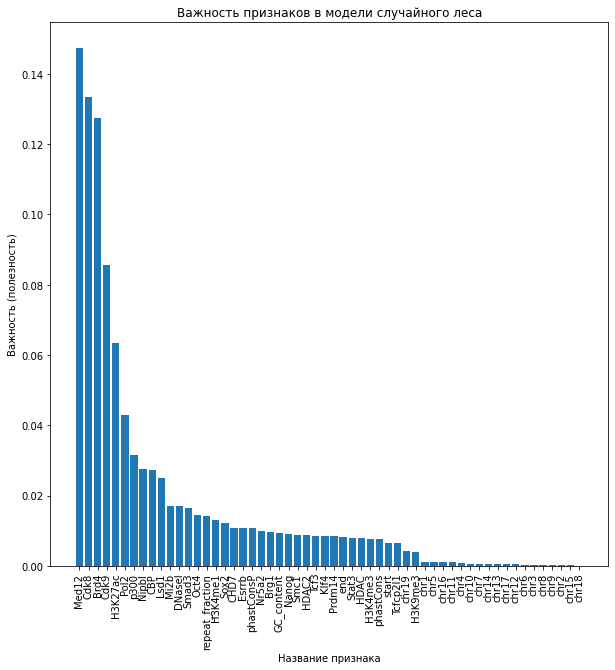

In [153]:
plt.figure(figsize=(10, 10))

plt.title('Важность признаков в модели случайного леса')
plt.ylabel('Важность (полезность)')
plt.xlabel('Название признака')

plt.bar(range(len(X_test_up.columns)), importances[indices])
plt.xticks(range(len(X_test_up.columns)),X_test_up.columns[indices],rotation=90)
plt.show()

#### Task 3 (3 points)

* Get feature importances for the best XGBoost model and compare results with RandomForest importances. (2 points)

* Compare results with the importances from the [original article](https://www.biorxiv.org/content/10.1101/105262v1.full) (1 point)



In [154]:
importances = best_model_XGB.feature_importances_

indices = np.argsort(importances)[::-1]

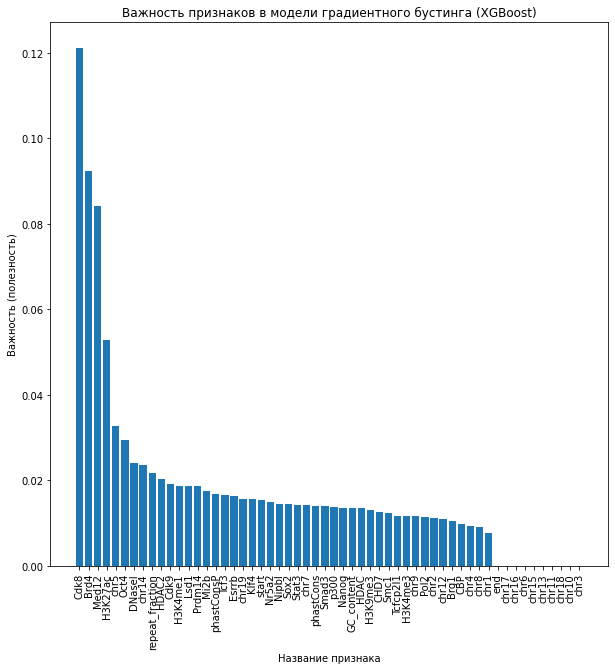

In [156]:
plt.figure(figsize=(10, 10))

plt.title('Важность признаков в модели градиентного бустинга (XGBoost)')
plt.ylabel('Важность (полезность)')
plt.xlabel('Название признака')

plt.bar(range(len(X_test_up.columns)), importances[indices])
plt.xticks(range(len(X_test_up.columns)),X_test_up.columns[indices],rotation=90)
plt.show()

Мы можем наблюдать значительные измения признаков. В отличии от модели случайного леса, в градиентном устинге получилось, что 5-ая хромосома иммет очень большое значение для энхансеров. Также поменялись местами 1 и 3 позиции в рейтинге значимости. Нельзя не отметить, что в модели случайного леса хромомсома не имела большого значения, однако в модели градиентного бустинга хромосоома имеет значение. 

Я был приятно удивлен, что мои данные не очень далеки от полученных авторами статьи. Группа факторов Cdk8, Brd4, H3K27ac, Med12 аналогична исследованиям заняла первые места со значительным отрывом от плато. Остальные факторы аналогично исследования перешли в плато. Однако факторы Pol2, Cdk9 ушли из лидерской группы на плато. 

#### Bonus Task (5 points)

Create additional analysis of the results/initial data (you can choose some of the analysis steps from the [original article](https://www.biorxiv.org/content/10.1101/105262v1.full)).

You can use additional sources like [Genome Browser](https://artyomovlab.wustl.edu/jbr/2018_h3k27ac_aging/).


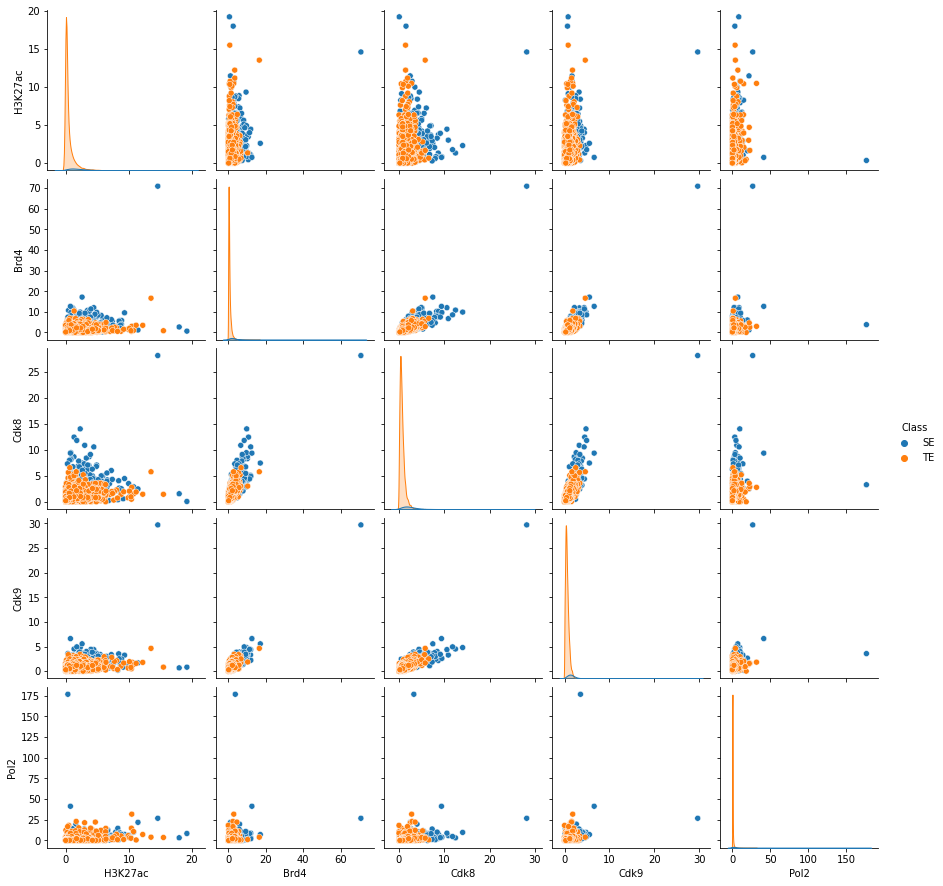

In [188]:
import seaborn as sns

sns.pairplot(data.drop(columns = ['chrom', 'start', 'end', 'H3K4me1', 'H3K4me3',
       'H3K9me3',  'Med12', 'p300', 'CBP', 
       'Lsd1', 'Brg1', 'Smc1', 'Nipbl', 'Mi2b', 'CHD7', 'HDAC2', 'HDAC',
       'DNaseI', 'Oct4', 'Sox2', 'Nanog', 'Smad3', 'Stat3', 'Tcf3', 'Esrrb',
       'Klf4', 'Prdm14', 'Tcfcp2I1', 'Nr5a2', 'AT_content', 'GC_content',
       'phastCons', 'phastConsP', 'repeat_fraction', 'length']), hue="Class", diag_kind = 'auto')

Рассмотрена диаграмма рассеяния. Видны некоторые зависимости - разделения. Поэтому попробуем пройтись по ним в рамках совместных гистограмм

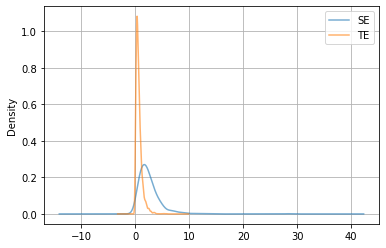

In [196]:
data.groupby('Class')['Cdk8'].plot.kde(alpha=0.6, grid = 60)
plt.legend();

No handles with labels found to put in legend.


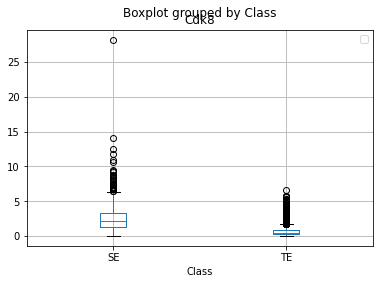

In [203]:
data.boxplot(column = 'Cdk8',by = 'Class')
plt.legend();

Типичные энхасеры имеют существенно меньшие значения Cdk8

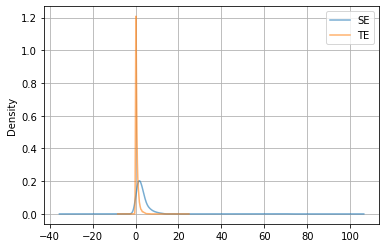

In [197]:
data.groupby('Class')['Brd4'].plot.kde(alpha=0.6, grid = 60)
plt.legend();

No handles with labels found to put in legend.


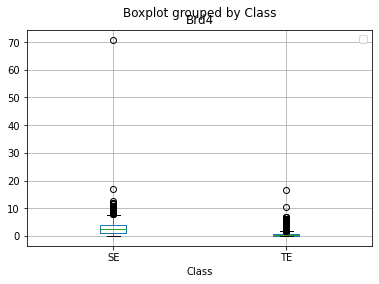

In [204]:
data.boxplot(column = 'Brd4',by = 'Class')
plt.legend();

Типичные энхасеры имеют существенно меньшие значения Brd4

In [ ]:
data.groupby('Class')['length'].plot.kde(alpha=0.6, grid = 60)
plt.legend();

Class
SE    AxesSubplot(0.125,0.125;0.775x0.755)
TE    AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

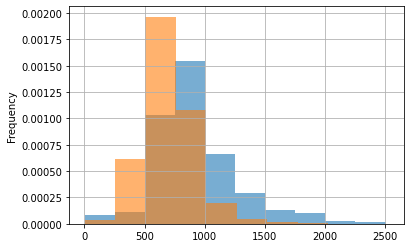

In [192]:
data.groupby('Class')['length'].plot.hist(alpha=0.6, density = True, grid = 20)
plt.legend();

In [ ]:
 Brd4, H3K27ac, Med12,  Pol2, Cdk9 